In [1]:

l = nx.laplacian_matrix(adj).todense()
L = nx.laplacian_matrix(G)
nL = csgraph.laplacian(l, normed=True)
degrees = dict(nx.degree(adj))
D = np.diag(list(degrees.values()))

A = nx.adjacency_matrix(adj)
A_dense = A.toarray()

normalized_gl = (D-A_dense)/2.19890275e+03

import numpy as np
from scipy.linalg import eigh
# compute the eigenvalues and eigenvectors of the Laplacian matrix
eps = 1e-8  # small positive constant
evals, evecs = eigh(normalized_gl, eigvals=(0, 76))




eigenvalues, eigenvectors = np.linalg.eigh(l)
sort_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sort_indices]
eigenvectors = eigenvectors[:, sort_indices]

def conv_matrix(x, days=14):
    output = np.zeros(shape=(days, 77, 77))
    for i in range(days-1):
        output[i,:,:] = np.corrcoef(x[:, :i])
    return output
conv_matrix_input = conv_matrix(x_matrix)

: 

: 

In [125]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("figure", dpi=120)

In [371]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
x = pd.read_csv('save.csv').to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(x)

n_batch = 64
n_timesteps = 40
n_pred = 3
nn_input = np.zeros(shape=(n_batch, n_timesteps, 77))
nn_output = np.zeros(shape=(n_batch, 77*n_pred))
for i in range(n_batch):
    nn_input[i,:,:] = x[:,i:i+n_timesteps].T
    nn_output[i,:] = x[:,i+n_timesteps:i+n_timesteps+n_pred].flatten()

nn_input = tf.convert_to_tensor(nn_input)
nn_output = tf.convert_to_tensor(nn_output)

# Prepare the output data
num_output = 77 * n_pred

# Define the LSTM model
model = Sequential()
model.add(LSTM(num_output, batch_input_shape=(n_batch,n_timesteps,77)))
model.add(Dense(num_output//2, activation='relu'))
model.add(Dense(num_output, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(nn_input, nn_output, epochs=100, batch_size=32)


Epoch 1/100
2/2 [==============================] - 1s 31ms/step - loss: 1.0164
Epoch 2/100
2/2 [==============================] - 0s 29ms/step - loss: 0.8441
Epoch 3/100
2/2 [==============================] - 0s 28ms/step - loss: 0.7248
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 0.6184
Epoch 5/100
2/2 [==============================] - 0s 30ms/step - loss: 0.5159
Epoch 6/100
2/2 [==============================] - 0s 31ms/step - loss: 0.4230
Epoch 7/100
2/2 [==============================] - 0s 35ms/step - loss: 0.3399
Epoch 8/100
2/2 [==============================] - 0s 33ms/step - loss: 0.2672
Epoch 9/100
2/2 [==============================] - 0s 34ms/step - loss: 0.2069
Epoch 10/100
2/2 [==============================] - 0s 33ms/step - loss: 0.1590
Epoch 11/100
2/2 [==============================] - 0s 32ms/step - loss: 0.1227
Epoch 12/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0963
Epoch 13/100
2/2 [==============================]

In [372]:
out = model.predict(nn_input)

2/2 [==============================] - 0s 12ms/step


In [444]:
class LSTMoutput:
    def __init__(self, n_timesteps):
        self.x = pd.read_csv('save.csv').to_numpy()
        self.scaler = StandardScaler()
        self.n_timesteps = n_timesteps
    def inverse_transform(self, input, timestep_of_output):
        scaler.fit(self.x[:,self.n_timesteps+timestep_of_output].reshape(-1,1))
        return scaler.inverse_transform(input.reshape(77,3)[:,timestep_of_output].reshape(1,-1)).reshape(77,1)
    
    def actual(self, timestep_of_output):
        return self.x[:,timestep_of_output]
        
        

In [454]:
pred_transformed_atl = []
for i in range(64):
    a = LSTMoutput(40+i)
    traffic = a.inverse_transform(out[i,:],0)[2,0]
    pred_transformed_atl.append(traffic)

In [528]:
padded = np.pad(np.array(pred_transformed_atl), (40,0))
value = np.append(padded, x[2,:40+64])
day = np.tile(np.arange(1,105),(2))
type = np.concatenate((np.array(['Predicted']*104), np.array(['Actual']*104)))
atl_plot = pd.DataFrame(np.vstack((value, day, type)).T)
atl_plot.columns = ['Value', 'Day', 'Type']
atl_plot[['Value', 'Day']] = atl_plot[['Value', 'Day']].astype(float)

[Text(0.5, 1.0, 'ATL Throughput - Training Results'),
 Text(0.5, 0, 'Days Since 1/1/20'),
 Text(0, 0.5, '# of Flights')]

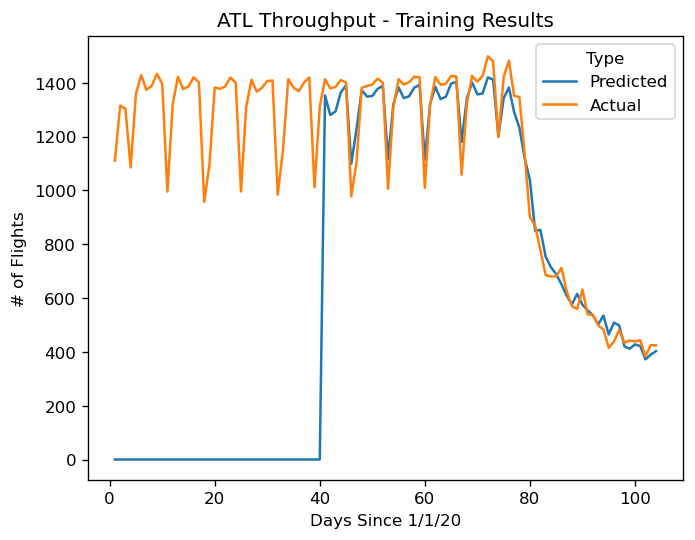

In [539]:
fig, ax = plt.subplots()
sns.lineplot(data=atl_plot, x='Day', y='Value', hue='Type', ax=ax)
ax.set(title='ATL Throughput - Training Results', xlabel='Days Since 1/1/20', ylabel='# of Flights')